In [33]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

##  Flowers Data

In [34]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

# from utils.helper import fn_plot_tf_hist

In [35]:
###----------------------
### Some basic parameters
###----------------------



inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'
valDir = 'valid'
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 10      # number of cycles to run
FLIP_MODE = 'horizontal_and_vertical'
ROTATION = (-0.1,0.1)
LR_PATIENCE = 10
LR_FACTOR = 0.1
BATCH_SIZE = 8    # inline of Training Rows being 60000
IMG_HEIGHT = 224   # ???
IMG_WIDTH = 224   # ???


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [36]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
print (physical_devices)

[]


In [38]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [39]:
'''import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''


data_dir = os.path.join(inpDir, subDir)
data_dir

'D:\\DNN\\input\\flower_photos'

In [40]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3407 files belonging to 5 classes.
Using 2726 files for training.
Found 3407 files belonging to 5 classes.
Using 681 files for validation.


In [41]:
#delete these lines -- if necessary

labels = []
for count, data in enumerate(train_ds) :
    imgs, lbls = data
    #print(count, ' : ', imgs.shape, lbls.shape)
    labels.append(lbls)

#len(labels)

unique, A, counts = tf.unique_with_counts(tf.concat(labels, axis = 0).numpy())

unique, A, counts

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 3, 4, 0])>,
 <tf.Tensor: shape=(2726,), dtype=int32, numpy=array([0, 0, 1, ..., 4, 0, 1])>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([517, 515, 559, 644, 491])>)

In [42]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [43]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [44]:
class_dict = {k: v for k, v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [45]:
num_classes = len(class_names)
num_classes

5

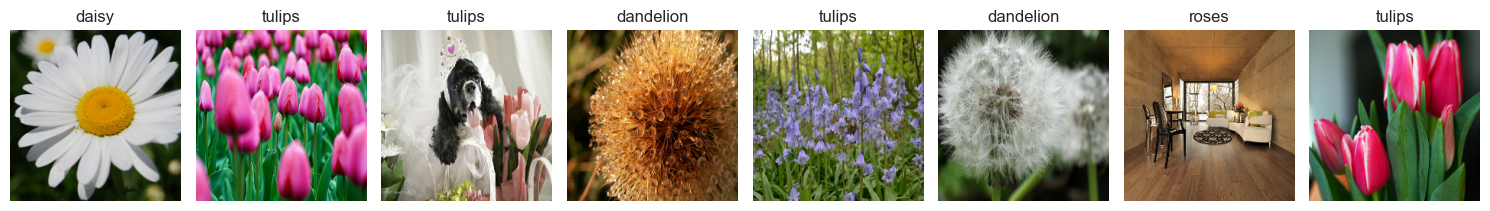

In [46]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

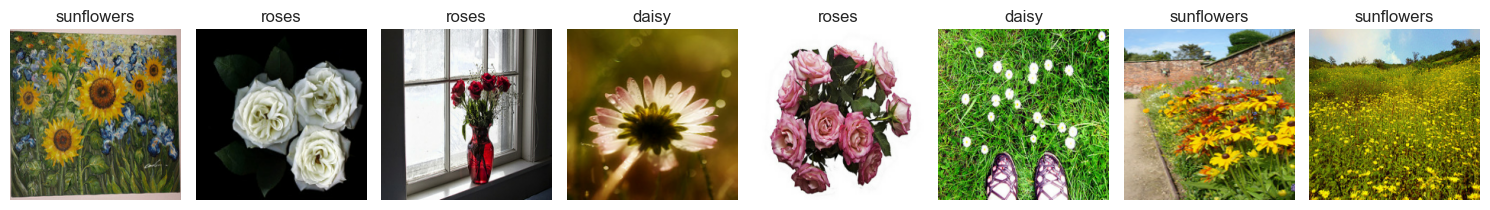

In [47]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

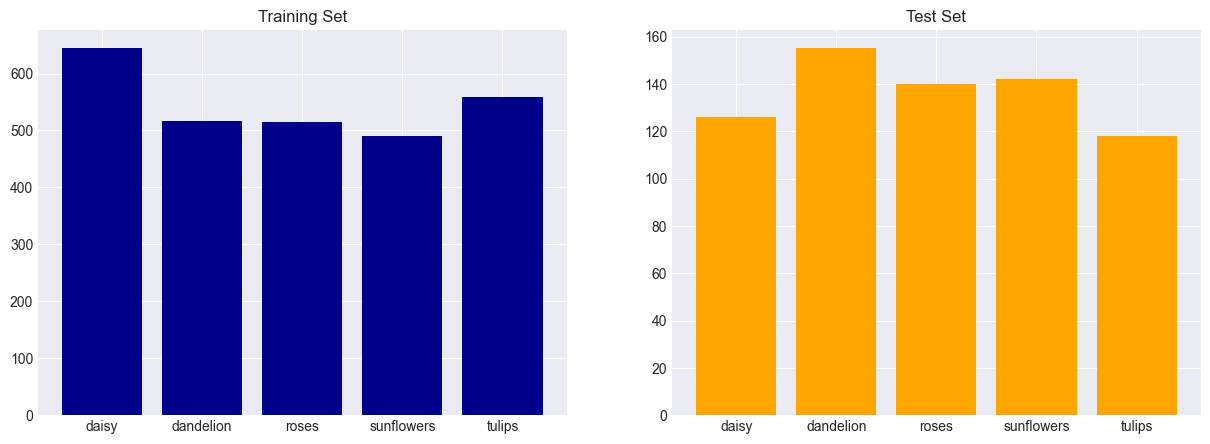

In [48]:
fn_plot_label(train_ds, test_ds)

In [49]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [50]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(224, 224, 3)

In [56]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                                include_top=True,
                                                input_shape=input_shape)

In [57]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [58]:
def build_model(input_shape, num_classes):

  krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

  model = tf.keras.Sequential()

  tf.keras.layers.Rescaling(1./255)

#---------------------------------------------------------------------------
#Augmentation Layers here

#------------------------------------------------------------------------------

  model.add(densenet_model)




  # Head

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(1664,kernel_initializer = krnl_init))

  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Activation(activation='relu'))

  model.add(tf.keras.layers.Dropout(0.5))


  
  model.add(tf.keras.layers.Dense(46,kernel_initializer = krnl_init))

  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Activation(activation='relu'))

  model.add(tf.keras.layers.Dropout(0.5))


  #output layer

  model.add(tf.keras.layers.Dense(num_classes,kernel_initializer = krnl_init))


  return model 

In [53]:
model = build_model(input_shape, num_classes)
model

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=ALPHA),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# checkpoint_path = os.path.join(modelDir, subDir, 'flowers')

# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path,
#     monitor='val_loss',
#     verbose=2,
#     save_best_only=True,
#     save_weights_only=True)

# es_checkpoint = tf.keras.callbacks.EarlyStopping( #early stopping call back, after some time 
#     monitor='val_loss',                           #if there is no change in loss then assume it is only your good weights
#     patience=PATIENCE,
#     mode='auto',
#     restore_best_weights=True
# )

# lr_checkpoint = tf.keras.callbacks.ReduceLROnPlateau(   #learning rate call back used for decreasing learning rate, when loss is not improving
#     monitor='val_loss',
#     factor=LR_FACTOR,
#     patience=LR_PATIENCE,
#     verbose=1

# )

In [60]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    # callbacks = [model_checkpoint, es_checkpoint, lr_checkpoint],
                    verbose=2)

Epoch 1/10



c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



341/341 - 129s - loss: 1.7494 - accuracy: 0.2311 - val_loss: 1.6079 - val_accuracy: 0.2276 - 129s/epoch - 378ms/step
Epoch 2/10
341/341 - 126s - loss: 1.6062 - accuracy: 0.2362 - val_loss: 1.6075 - val_accuracy: 0.2276 - 126s/epoch - 370ms/step
Epoch 3/10
341/341 - 123s - loss: 1.6054 - accuracy: 0.2362 - val_loss: 1.6075 - val_accuracy: 0.2276 - 123s/epoch - 360ms/step
Epoch 4/10
341/341 - 123s - loss: 1.6051 - accuracy: 0.2362 - val_loss: 1.6076 - val_accuracy: 0.2276 - 123s/epoch - 359ms/step
Epoch 5/10
341/341 - 122s - loss: 1.6050 - accuracy: 0.2362 - val_loss: 1.6078 - val_accuracy: 0.2276 - 122s/epoch - 357ms/step
Epoch 6/10
341/341 - 124s - loss: 1.6050 - accuracy: 0.2362 - val_loss: 1.6079 - val_accuracy: 0.2276 - 124s/epoch - 363ms/step
Epoch 7/10
341/341 - 124s - loss: 1.6050 - accuracy: 0.2362 - val_loss: 1.6079 - val_accuracy: 0.2276 - 124s/epoch - 364ms/step
Epoch 8/10
341/341 - 124s - loss: 1.6050 - accuracy: 0.2362 - val_loss: 1.6080 - val_accuracy: 0.2276 - 124s/epoch

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 96)        384       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 26, 26, 256)       1

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
yhat = model.predict(test_ds)
y_test = np.concatenate([y for X,y in test_ds],axis=0).squeeze()
y_pred = yhat.argmax(axis=1)
print('Accuracy score on Test Data: {:.4f}'.format(accuracy_score(y_test,y_pred)))

86/86 [==============================] - 7s 73ms/step
Accuracy score on Test Data: 0.2276


# Validation Data

In [ ]:
val_dir = os.path.join(inpDir,valDir)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,validation_split = None,seed = RANDOM_STATE,
                                                     image_size = [IMG_HEIGHT,IMG_WIDTH],
                                                     batch_size = BATCH_SIZE)

In [64]:
test_loss,test_acc = model.evaluate(val_ds,verbose=1)

NameError: name 'val_ds' is not defined

In [65]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.749426,0.231108,1.607888,0.227606
1,1.606184,0.236244,1.607466,0.227606
2,1.605420,0.236244,1.607498,0.227606
3,1.605133,0.236244,1.607634,0.227606
4,1.605030,0.236244,1.607763,0.227606


In [66]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    
    

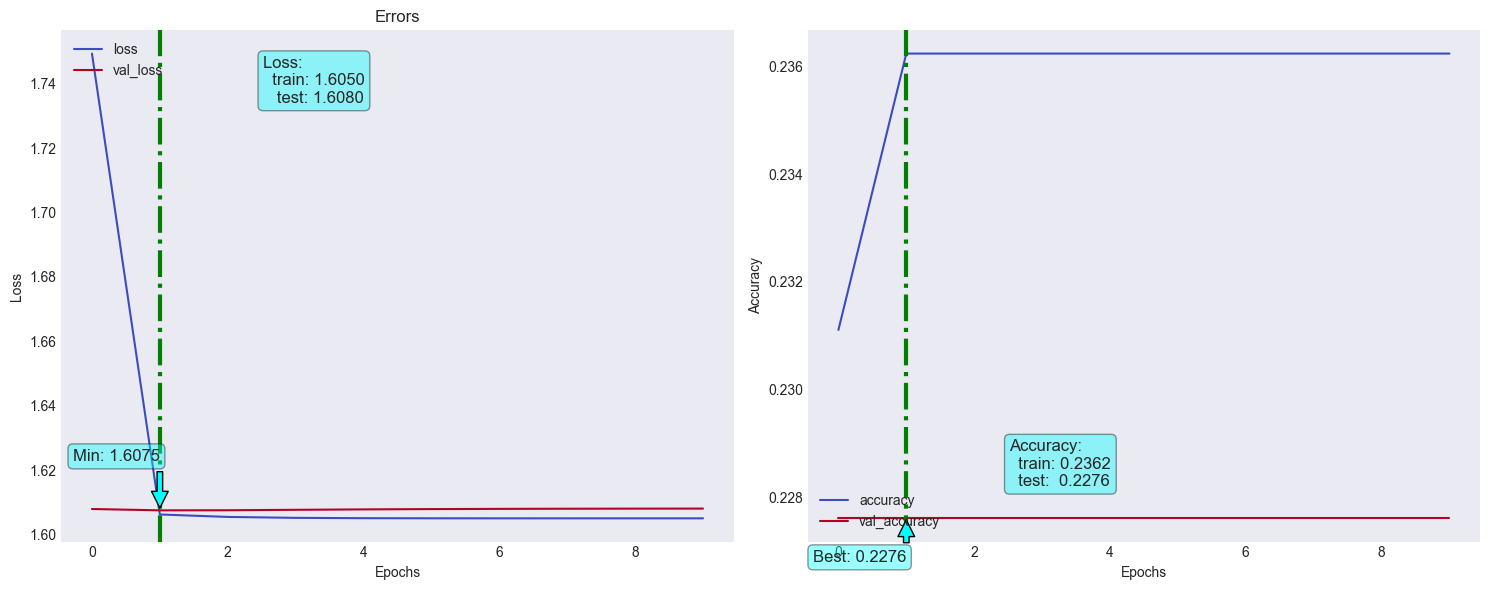

In [67]:
fn_plot_tf_hist(loss_df)

In [ ]:
'''
tf.keras.utils.plot_model(model, 'model.png',
                          show_shapes=True,
                          show_dtype=True,
                          dpi=96,
                          show_layer_activations=True)
'''

In [ ]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
    fill_mode='nearest',
    seed = RANDOM_STATE
)
plt.figure()

img_num = 0
for images, labels in train_ds.take(1) :
    out_images = layer(images)
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.title("Rotated")
    plt.imshow(out_images[img_num].numpy().astype('uint16'))
    plt.grid(False)
    